# Librerias

In [4]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression,Ridge, Lasso,LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
# sklearn para outliers
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import r2_score, mean_squared_error
# sklear para codificacion
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# estadisticas
from scipy.stats import ks_2samp
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# graficos
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.dates as mdates
import plotly.io as pio
pio.templates.default = "plotly_white"


# Carga datos

In [5]:
#df_original_variables=pd.read_excel('/content/drive/MyDrive/Magister/capstone/datos/df_final_v3.xlsx')
df_original_variables=pd.read_excel('ArchivosExcel/df_final_v4.xlsx')
df_original_variables.drop('Missing Values',inplace=True,axis=1)
df_otras_variables=pd.read_excel('ArchivosExcel//df_otras_variables.xlsx')
df_otras_variables.drop('Unnamed: 0',inplace=True,axis=1)
df_raw=pd.merge(df_original_variables,df_otras_variables,on=['Fecha','Turno'],how='left')
df_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1104 entries, 0 to 1103
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Fecha              1104 non-null   datetime64[ns]
 1   Alim CuT           870 non-null    float64       
 2   Alim CuS           878 non-null    float64       
 3   Alim CuI           947 non-null    float64       
 4   Ag (ppm)           805 non-null    float64       
 5   Pb (ppm)           800 non-null    float64       
 6   Fe %               879 non-null    float64       
 7   Rec Turno CuT      806 non-null    float64       
 8   P80 Alim Ro300     1010 non-null   float64       
 9   pH Ro300           1026 non-null   float64       
 10  Tratamiento turno  1077 non-null   float64       
 11  Sol Cit            857 non-null    float64       
 12  Turno              1104 non-null   object        
 13  Aire_Celdas        1084 non-null   float64       
 14  Nivel_Ce

In [6]:
df_raw.rename(columns={'Rec Turno CuT':'Recuperacion_Turno'},inplace=True)

In [7]:
df_raw.head()

,Fecha,Alim CuT,Alim CuS,Alim CuI,Ag (ppm),Pb (ppm),Fe %,Recuperacion_Turno,P80 Alim Ro300,pH Ro300,Tratamiento turno,Sol Cit,Turno,Aire_Celdas,Nivel_Celdas
0,2024-01-01,0.70,0.08,0.62,5.0,23.0,2.61,79.002079,209.0,10.4,7827.943419,0.05,A,109.206438,18.555931
1,2024-01-01,0.64,0.08,0.56,4.0,29.0,2.72,78.174603,228.0,11.2,7863.186581,0.08,B,109.041660,21.650116
2,2024-01-02,0.78,0.09,0.69,4.0,42.0,2.99,82.123510,198.0,10.8,6781.529837,0.08,A,113.904591,22.948124
3,2024-01-02,NaN,NaN,0.00,NaN,NaN,NaN,81.029204,269.0,11.2,7114.150163,NaN,B,106.029497,24.355974
4,2024-01-03,0.69,0.09,0.60,4.0,51.0,2.99,83.898095,168.0,11.0,8090.793631,0.07,A,117.000601,22.792185


# Datos faltantes

eliminar los registros donde la variable **recuperacion_turno** es 0 o nula

In [8]:
df_clean=df_raw.query('~Recuperacion_Turno.isnull()').copy()
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 806 entries, 0 to 961
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Fecha               806 non-null    datetime64[ns]
 1   Alim CuT            685 non-null    float64       
 2   Alim CuS            683 non-null    float64       
 3   Alim CuI            730 non-null    float64       
 4   Ag (ppm)            591 non-null    float64       
 5   Pb (ppm)            586 non-null    float64       
 6   Fe %                648 non-null    float64       
 7   Recuperacion_Turno  806 non-null    float64       
 8   P80 Alim Ro300      770 non-null    float64       
 9   pH Ro300            773 non-null    float64       
 10  Tratamiento turno   806 non-null    float64       
 11  Sol Cit             631 non-null    float64       
 12  Turno               806 non-null    object        
 13  Aire_Celdas         804 non-null    float64       
 14 

creamos una variable que cuenta la cantidad de datos faltantes por registro (**missing values**)

In [9]:
df_clean['Missing Values']=df_clean.isna().sum(axis=1)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 806 entries, 0 to 961
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Fecha               806 non-null    datetime64[ns]
 1   Alim CuT            685 non-null    float64       
 2   Alim CuS            683 non-null    float64       
 3   Alim CuI            730 non-null    float64       
 4   Ag (ppm)            591 non-null    float64       
 5   Pb (ppm)            586 non-null    float64       
 6   Fe %                648 non-null    float64       
 7   Recuperacion_Turno  806 non-null    float64       
 8   P80 Alim Ro300      770 non-null    float64       
 9   pH Ro300            773 non-null    float64       
 10  Tratamiento turno   806 non-null    float64       
 11  Sol Cit             631 non-null    float64       
 12  Turno               806 non-null    object        
 13  Aire_Celdas         804 non-null    float64       
 14 

gráfico de Missing Values por regitro

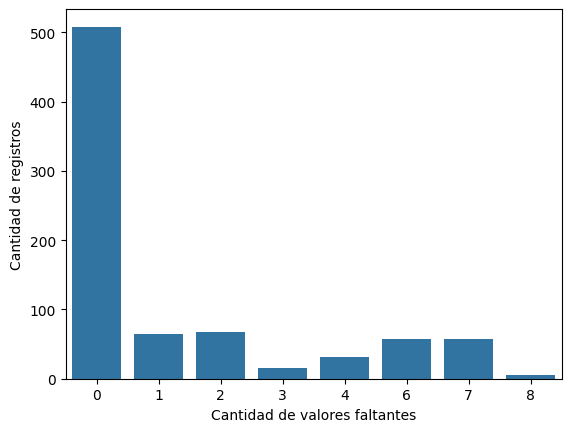

In [10]:
tabla=df_clean.groupby('Missing Values').size()
sns.barplot(tabla)
plt.ylabel('Cantidad de registros')
plt.xlabel('Cantidad de valores faltantes')
plt.show()

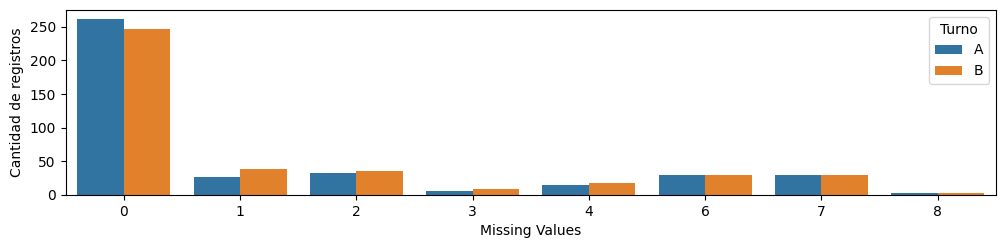

In [11]:
tabla_MV_turno=df_clean.groupby(['Missing Values','Turno']).size()
tabla_MV_turno.name='Cantidad de registros'
tabla_MV_turno=tabla_MV_turno.reset_index()
figsize = (12, 1.2 * len(tabla_MV_turno['Turno'].unique()))
plt.figure(figsize=figsize)
sns.barplot(tabla_MV_turno, y='Cantidad de registros', x='Missing Values', hue='Turno')
plt.show()

reducir solo a registros que tienen 4 o menos variables faltantes

In [12]:
df_clean.query("`Missing Values` < 5",inplace=True)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 685 entries, 0 to 961
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Fecha               685 non-null    datetime64[ns]
 1   Alim CuT            685 non-null    float64       
 2   Alim CuS            683 non-null    float64       
 3   Alim CuI            685 non-null    float64       
 4   Ag (ppm)            591 non-null    float64       
 5   Pb (ppm)            586 non-null    float64       
 6   Fe %                648 non-null    float64       
 7   Recuperacion_Turno  685 non-null    float64       
 8   P80 Alim Ro300      654 non-null    float64       
 9   pH Ro300            656 non-null    float64       
 10  Tratamiento turno   685 non-null    float64       
 11  Sol Cit             614 non-null    float64       
 12  Turno               685 non-null    object        
 13  Aire_Celdas         683 non-null    float64       
 14 

In [13]:
# Calcular la cantidad de NaN y el total de entradas por columna, excepto 'Fecha'
variables_no_numericas=['Fecha','Turno']
numeric_cols = df_clean.columns.drop(variables_no_numericas)
nan_counts = df_clean[numeric_cols].isna().sum()
total_counts = len(df_clean)

# Calcular el porcentaje de datos no NaN
non_nan_percentage = (1 - nan_counts / total_counts) * 100
nan_percentage=(nan_counts/total_counts)*100

# Crear un DataFrame con los resultados
results_df = pd.DataFrame({
    'Var': nan_counts.index,
    'count_nan': nan_counts.values,
    'Total Registros': total_counts,
    'Porcentaje completos': non_nan_percentage.values,
    'Porcentaje faltantes':nan_percentage.values
})

# Ordenar los resultados por porcentaje en orden decreciente
results_df = results_df.sort_values(by='Porcentaje completos', ascending=False)
results_df = results_df.reset_index(drop=True)
results_df

,Var,count_nan,Total Registros,Porcentaje completos,Porcentaje faltantes
0,Alim CuT,0,685,100.000000,0.000000
1,Alim CuI,0,685,100.000000,0.000000
2,Recuperacion_Turno,0,685,100.000000,0.000000
3,Tratamiento turno,0,685,100.000000,0.000000
4,Missing Values,0,685,100.000000,0.000000
5,Alim CuS,2,685,99.708029,0.291971
6,Aire_Celdas,2,685,99.708029,0.291971
7,Nivel_Celdas,2,685,99.708029,0.291971
8,pH Ro300,29,685,95.766423,4.233577
9,P80 Alim Ro300,31,685,95.474453,4.525547


In [14]:
# Crear un gráfico de barras con Plotly
fig = px.bar(results_df.query("Var!='Missing Values'"), x='Var', y='Porcentaje completos',
             title='Porcentaje de Datos Disponibles por Variable',
             labels={'Var': 'Variable', 'Porcentaje completos': 'Porcentaje de Datos No NaN (%)'},
             text='Porcentaje completos')

# Añadir estilo al gráfico
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.update_layout(xaxis_tickangle=-45)

# Ajustar manualmente el tamaño del gráfico
fig.update_layout(width=1000, height=800)  # Cambia estos valores según tus necesidades

# Mostrar el gráfico
fig.show()

# Recuperación de cobre

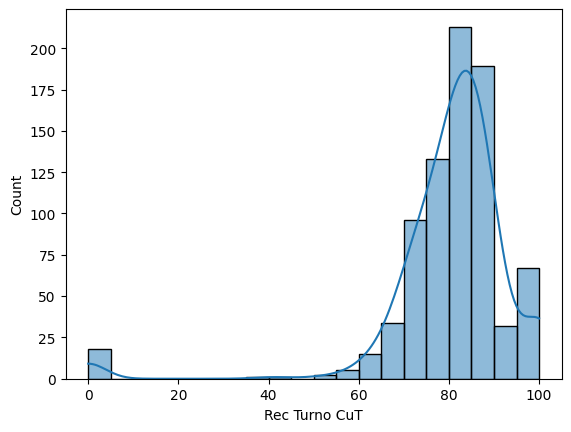

In [15]:
promedio_recuperacion=df_original_variables['Rec Turno CuT'].mean()
mediana_recuperacion=df_original_variables['Rec Turno CuT'].median()
meta_recuperacion=86
sns.histplot(df_original_variables['Rec Turno CuT'], bins=20, kde=True)
#plt.vlines(promedio_recuperacion, 0, 120, colors='r', linestyles='dashed', label='Promedio recuperación')
#plt.vlines(mediana_recuperacion, 0, 120, colors='b', linestyles='dashed', label='Mediana recuperación')
#plt.vlines(meta_recuperacion, 0, 120, colors='g', linestyles='dashed', label='Meta recuperación')
#plt.text(promedio_recuperacion, 120, f'Prom:{promedio_recuperacion:.0f}', color='r', fontsize=8, ha='right')
#plt.text(mediana_recuperacion, 120, f'Med:{mediana_recuperacion:.0f}', color='b', fontsize=8, ha='left')
#plt.text(meta_recuperacion, 120, f'Meta:{meta_recuperacion}', color='g', fontsize=8, ha='left')
#plt.legend(loc='upper left')
plt.show()

In [16]:
df_clean.Recuperacion_Turno.describe()

count    685.000000
mean      80.714153
std       14.873061
min        0.000000
25%       76.390633
50%       82.604460
75%       87.121633
max      100.000000
Name: Recuperacion_Turno, dtype: float64

In [17]:
df_clean.query("Recuperacion_Turno<100 and Recuperacion_Turno>0",inplace=True)
#df_clean.query("Recuperacion_Turno>0",inplace=True)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 605 entries, 0 to 961
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Fecha               605 non-null    datetime64[ns]
 1   Alim CuT            605 non-null    float64       
 2   Alim CuS            603 non-null    float64       
 3   Alim CuI            605 non-null    float64       
 4   Ag (ppm)            518 non-null    float64       
 5   Pb (ppm)            514 non-null    float64       
 6   Fe %                569 non-null    float64       
 7   Recuperacion_Turno  605 non-null    float64       
 8   P80 Alim Ro300      575 non-null    float64       
 9   pH Ro300            581 non-null    float64       
 10  Tratamiento turno   605 non-null    float64       
 11  Sol Cit             537 non-null    float64       
 12  Turno               605 non-null    object        
 13  Aire_Celdas         603 non-null    float64       
 14 

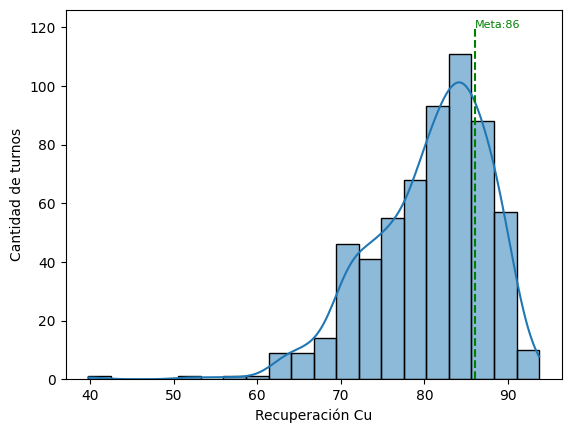

In [58]:
promedio_recuperacion=df_clean['Recuperacion_Turno'].mean()
mediana_recuperacion=df_clean['Recuperacion_Turno'].median()
meta_recuperacion=86
sns.histplot(df_clean['Recuperacion_Turno'], bins=20, kde=True)
#plt.vlines(promedio_recuperacion, 0, 120, colors='r', linestyles='dashed', label='Promedio recuperación')
#plt.vlines(mediana_recuperacion, 0, 120, colors='b', linestyles='dashed', label='Mediana recuperación')
plt.vlines(meta_recuperacion, 0, 120, colors='g', linestyles='dashed', label='Meta recuperación')
#plt.text(promedio_recuperacion, 120, f'Prom:{promedio_recuperacion:.0f}', color='r', fontsize=8, ha='right')
#plt.text(mediana_recuperacion, 120, f'Med:{mediana_recuperacion:.0f}', color='b', fontsize=8, ha='left')
plt.text(meta_recuperacion, 120, f'Meta:{meta_recuperacion}', color='g', fontsize=8, ha='left')
#plt.legend(loc='upper left')
plt.ylabel('Cantidad de turnos')
plt.xlabel('Recuperación Cu')
plt.show()

hacer tabla de recuperacion x dia

In [19]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 605 entries, 0 to 961
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Fecha               605 non-null    datetime64[ns]
 1   Alim CuT            605 non-null    float64       
 2   Alim CuS            603 non-null    float64       
 3   Alim CuI            605 non-null    float64       
 4   Ag (ppm)            518 non-null    float64       
 5   Pb (ppm)            514 non-null    float64       
 6   Fe %                569 non-null    float64       
 7   Recuperacion_Turno  605 non-null    float64       
 8   P80 Alim Ro300      575 non-null    float64       
 9   pH Ro300            581 non-null    float64       
 10  Tratamiento turno   605 non-null    float64       
 11  Sol Cit             537 non-null    float64       
 12  Turno               605 non-null    object        
 13  Aire_Celdas         603 non-null    float64       
 14 

In [20]:
tabla_recuperacion_dia=df_clean.groupby(['Fecha','Turno']).agg({'Recuperacion_Turno':'sum','Tratamiento turno':'sum'}).reset_index()
tabla_recuperacion_dia['Mult']=tabla_recuperacion_dia['Recuperacion_Turno']*tabla_recuperacion_dia['Tratamiento turno']
tabla_recuperacion_dia=tabla_recuperacion_dia.groupby('Fecha').agg({'Mult':'sum','Tratamiento turno':'sum'}).reset_index()
tabla_recuperacion_dia['Recuperacion']=tabla_recuperacion_dia['Mult']/tabla_recuperacion_dia['Tratamiento turno']
tabla_recuperacion_dia=tabla_recuperacion_dia[['Fecha','Recuperacion']]
tabla_recuperacion_dia.dropna(inplace=True)
tabla_recuperacion_dia['indice']=tabla_recuperacion_dia.index
tabla_recuperacion_dia

,Fecha,Recuperacion,indice
0,2023-01-01,85.071503,0
1,2023-01-02,86.887817,1
2,2023-01-03,74.630814,2
3,2023-01-04,71.853373,3
4,2023-01-05,71.282724,4
...,...,...,...
334,2024-07-02,77.769231,334
335,2024-07-03,73.481372,335
336,2024-07-04,79.389120,336
337,2024-07-05,80.392294,337


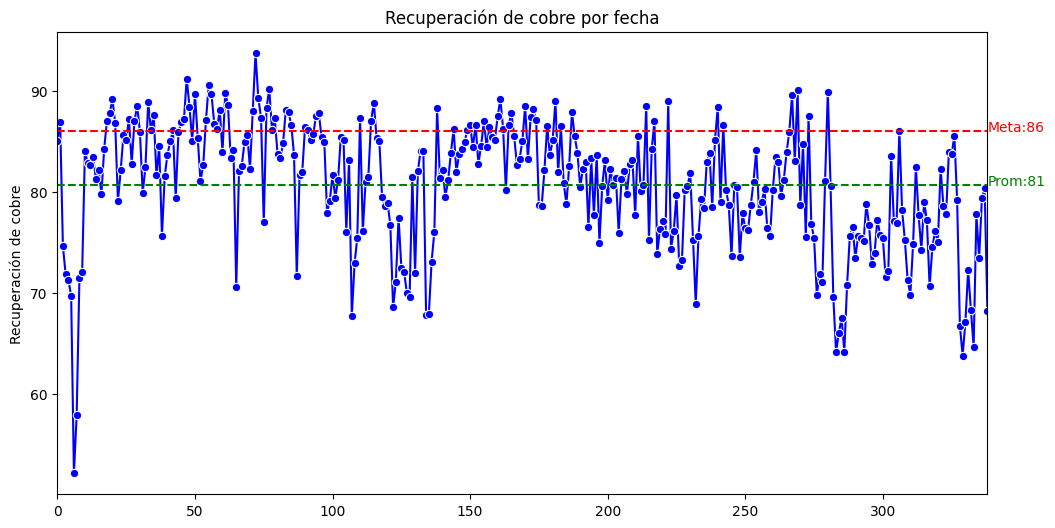

In [21]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=tabla_recuperacion_dia,x=tabla_recuperacion_dia.index, y='Recuperacion', marker='o', color='blue',estimator=None)
plt.title('Recuperación de cobre por fecha')
plt.ylabel('Recuperación de cobre')

minima = tabla_recuperacion_dia.index.min()
maxima = tabla_recuperacion_dia.index.max()

plt.hlines(meta_recuperacion, minima, maxima, colors='r', linestyles='dashed', label='Meta recuperación')
plt.text(maxima, meta_recuperacion, f'Meta:{meta_recuperacion}', color='r', fontsize=10, ha='left')

plt.hlines(promedio_recuperacion, minima, maxima, colors='g', linestyles='dashed', label='Promedio recuperación')
plt.text(maxima, promedio_recuperacion, f'Prom:{promedio_recuperacion:.0f}', color='g', fontsize=10, ha='left')

#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))  # Aquí defines el intervalo de 15 días
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formato de fecha año-mes-día
plt.xlabel('')
#plt.xticks(rotation=90)
plt.xlim(minima, maxima)

plt.show()


In [22]:
df_clean['cumplimiento']=df_clean['Recuperacion_Turno']>=meta_recuperacion
tabla_cumplimiento = df_clean.groupby(['Turno']).agg({'cumplimiento': 'sum','Recuperacion_Turno':'count'})
tabla_cumplimiento = tabla_cumplimiento.rename(columns={'Recuperacion_Turno':'cantidad_turnos'})
tabla_cumplimiento['porcentaje_cumplimiento']=tabla_cumplimiento['cumplimiento']/tabla_cumplimiento['cantidad_turnos']
tabla_cumplimiento['porcentaje_no_cumplimiento']=1-tabla_cumplimiento['porcentaje_cumplimiento']
tabla_cumplimiento = tabla_cumplimiento.reset_index()
tabla_cumplimiento

,Turno,cumplimiento,cantidad_turnos,porcentaje_cumplimiento,porcentaje_no_cumplimiento
0,A,75,305,0.245902,0.754098
1,B,67,300,0.223333,0.776667


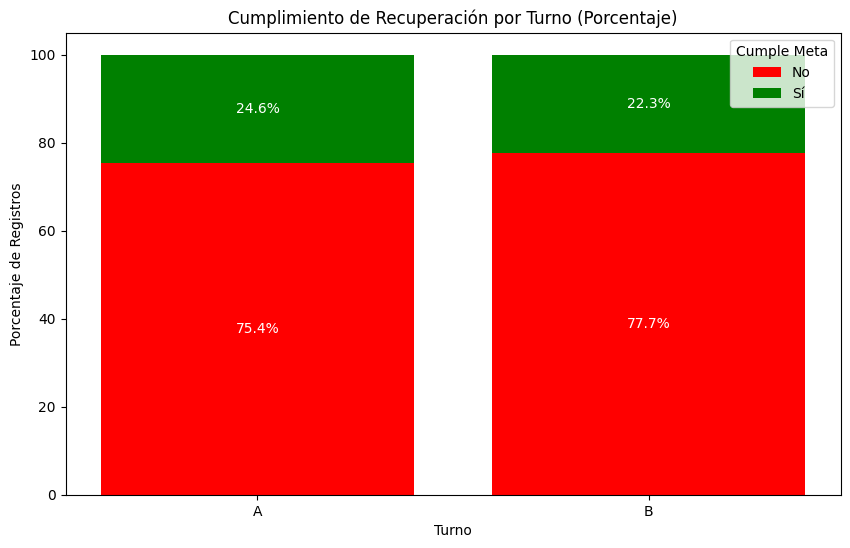

In [23]:
df_clean['Cumple_Meta'] = df_clean['Recuperacion_Turno'] >= meta_recuperacion
tabla_cumplimiento = df_clean.groupby(['Turno', 'Cumple_Meta'])['Recuperacion_Turno'].count().reset_index()
tabla_cumplimiento = tabla_cumplimiento.rename(columns={'Recuperacion_Turno': 'Cantidad'})
tabla_cumplimiento = tabla_cumplimiento.pivot(index='Turno', columns='Cumple_Meta', values='Cantidad').fillna(0)

# Calcula el porcentaje para cada turno
tabla_cumplimiento_pct = tabla_cumplimiento.div(tabla_cumplimiento.sum(axis=1), axis=0) * 100

# Crear el gráfico de barras apiladas con porcentajes
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['red', 'green']  # Puedes cambiar los colores si lo deseas

# barras apiladas
bottom = np.zeros(len(tabla_cumplimiento_pct))
for i, col in enumerate(tabla_cumplimiento_pct.columns):
    ax.bar(tabla_cumplimiento_pct.index, tabla_cumplimiento_pct[col], bottom=bottom, label=col, color=colors[i])
    bottom += tabla_cumplimiento_pct[col]

ax.set_title('Cumplimiento de Recuperación por Turno (Porcentaje)')
ax.set_ylabel('Porcentaje de Registros')
ax.set_xlabel('Turno')
ax.legend(title='Cumple Meta', labels=['No', 'Sí'])

# Agregar etiquetas de porcentaje
for i, rect in enumerate(ax.patches):
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x() + width / 2
    y = rect.get_y() + height / 2

    if height > 0:  # Solo agrega etiquetas si la altura es mayor a 0
        label_text = f'{height:.1f}%'
        ax.text(x, y, label_text, ha='center', va='center', color='white', fontsize=10)

plt.show()

# Visualización inicial de Variables

In [24]:
def graficos_variables(df, variables_excluidas=None):
    # Si no se especifican variables excluidas, usa las predeterminadas
    if variables_excluidas is None:
        variables_excluidas = ['Fecha', 'Recuperacion_Turno']

    # Seleccionar columnas numéricas excluyendo las variables indicadas
    numeric_columns = df.select_dtypes(include='number').drop(columns=variables_excluidas, errors='ignore')

    # Definir el número de filas y columnas en el layout de subplots
    num_cols = 4  # Ajusta este valor según el espacio que prefieras
    num_rows = math.ceil(numeric_columns.shape[1] / num_cols)

    # Crear el tamaño de la figura
    plt.figure(figsize=(20, num_rows * 5))

    # Graficar cada columna como un histograma en un subplot diferente
    for i, col in enumerate(numeric_columns.columns):
        plt.subplot(num_rows, num_cols, i + 1)
        sns.histplot(x=numeric_columns[col], kde=True)
        plt.title(col)
        plt.ylabel('')  # Elimina la etiqueta del eje y para ahorrar espacio

    # Ajustar los espacios entre subplots
    plt.tight_layout()
    plt.show()

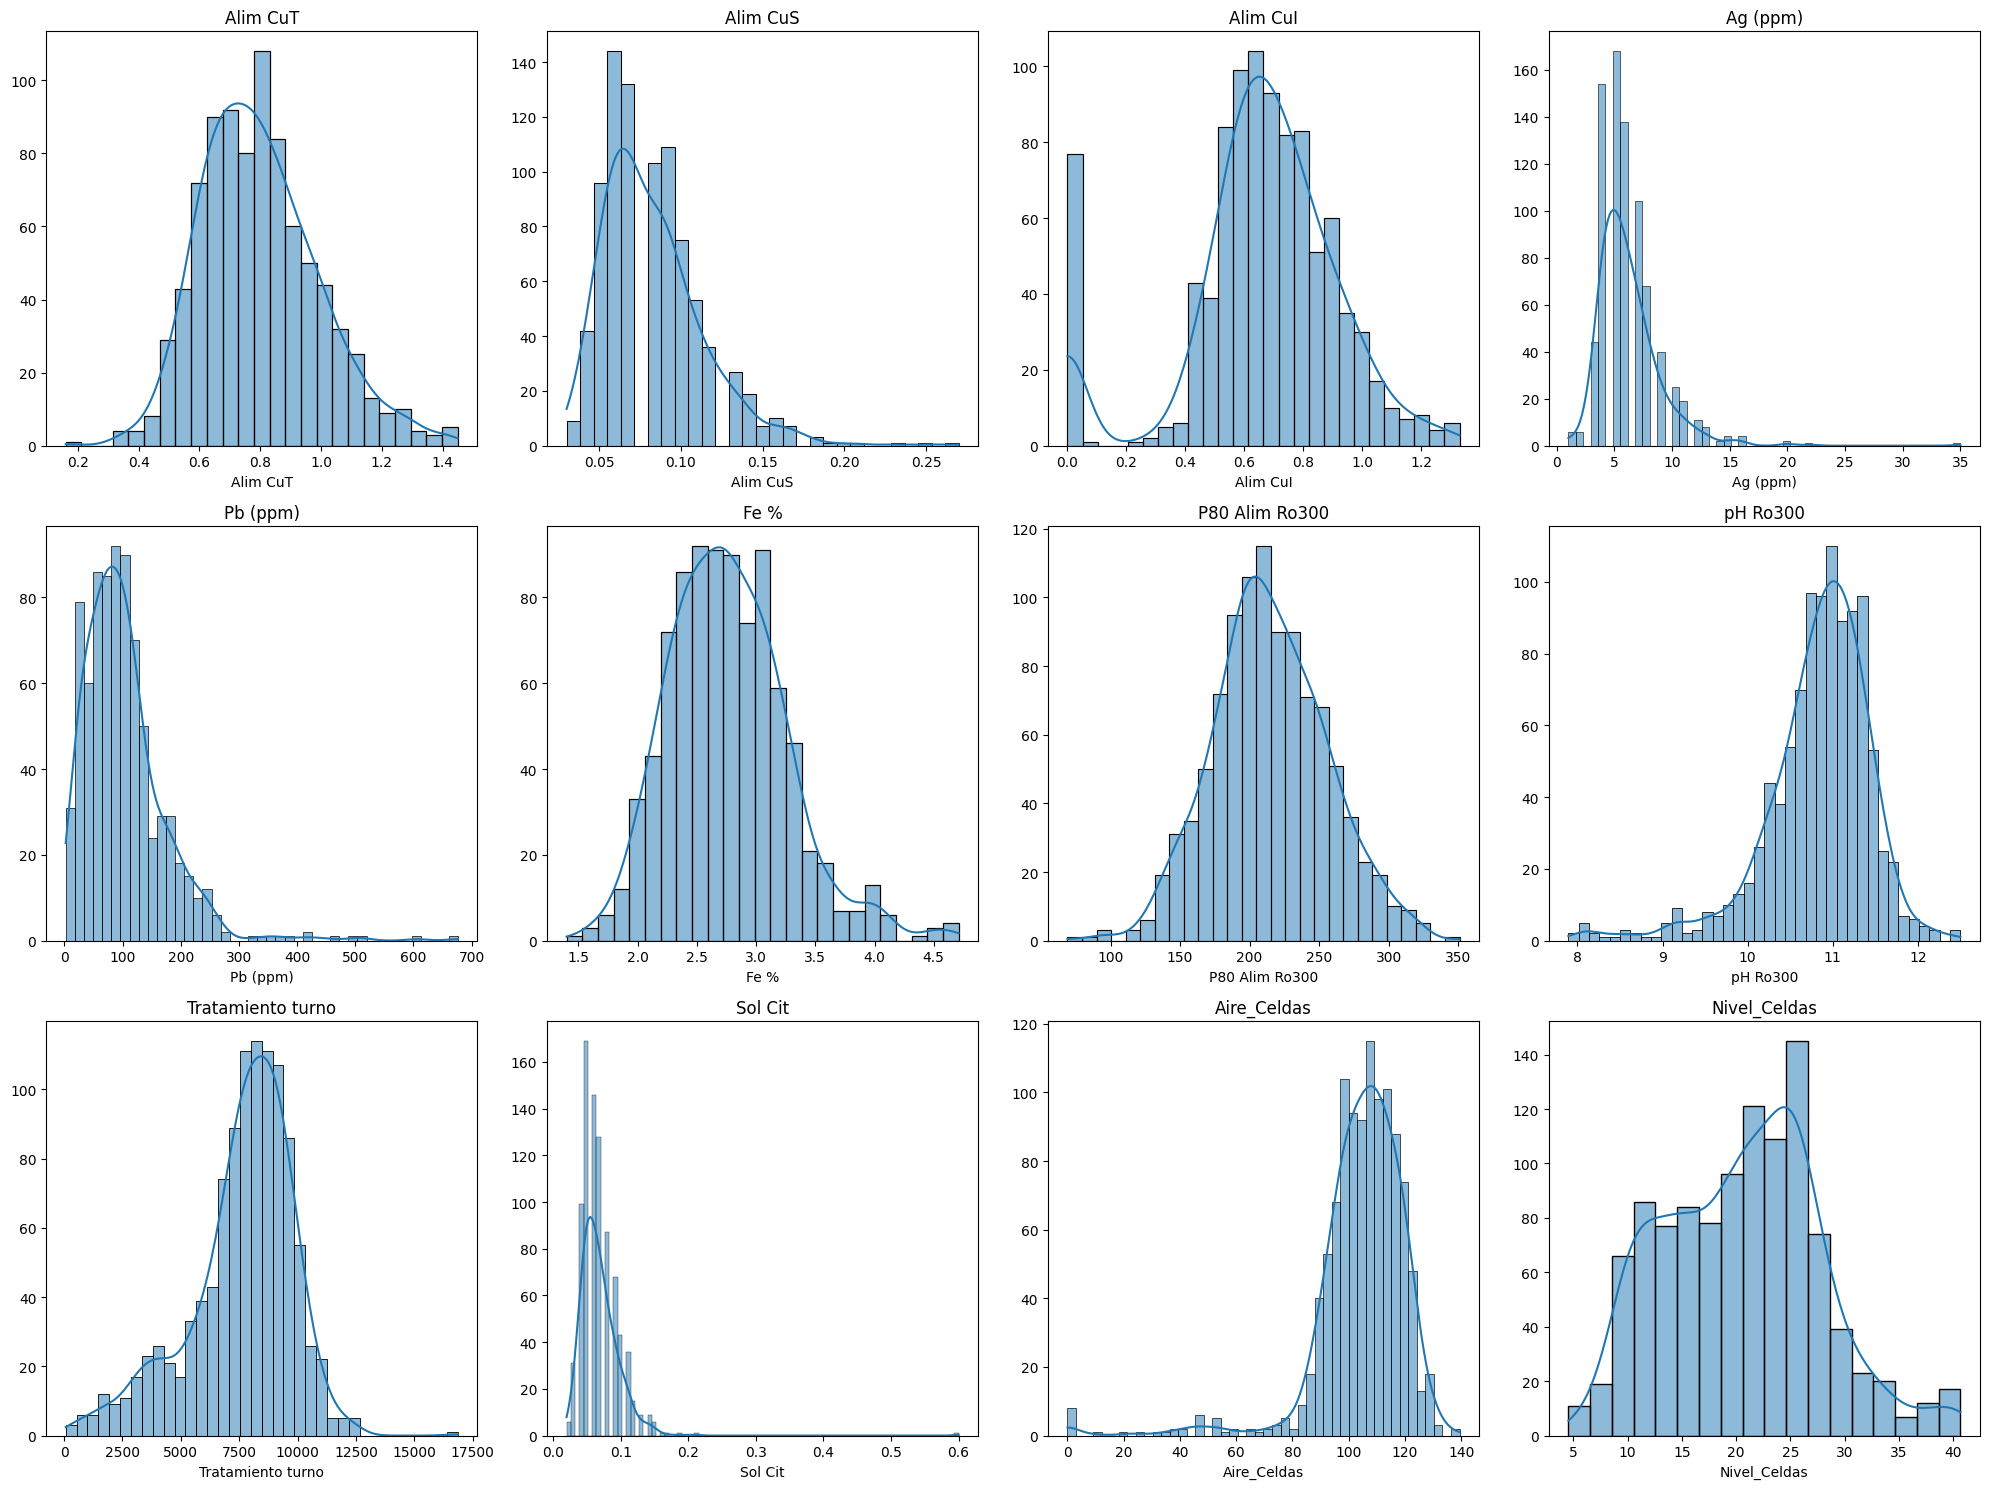

In [25]:
graficos_variables(df_raw.drop(columns=['Turno','Recuperacion_Turno']))

# Missing Values

In [26]:
df_clean['Missing Values'].value_counts()

Missing Values
0    442
2     61
1     58
4     30
3     14
Name: count, dtype: int64

In [27]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 605 entries, 0 to 961
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Fecha               605 non-null    datetime64[ns]
 1   Alim CuT            605 non-null    float64       
 2   Alim CuS            603 non-null    float64       
 3   Alim CuI            605 non-null    float64       
 4   Ag (ppm)            518 non-null    float64       
 5   Pb (ppm)            514 non-null    float64       
 6   Fe %                569 non-null    float64       
 7   Recuperacion_Turno  605 non-null    float64       
 8   P80 Alim Ro300      575 non-null    float64       
 9   pH Ro300            581 non-null    float64       
 10  Tratamiento turno   605 non-null    float64       
 11  Sol Cit             537 non-null    float64       
 12  Turno               605 non-null    object        
 13  Aire_Celdas         603 non-null    float64       
 14 

In [29]:
date_cols = df_clean.select_dtypes(include=['datetime']).columns  # Identifica columnas de fecha
cat_columns=df_clean.select_dtypes(include=['object']).columns
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns  # Identifica columnas numéricas

# Solo aplica imputación en columnas numéricas
#imputer = IterativeImputer(estimator=RandomForestRegressor(), random_state=42)
imputer = IterativeImputer(estimator=RandomForestRegressor(),skip_complete=True, random_state=42)
df_numeric_imputed = imputer.fit_transform(df_clean[numeric_cols])
df_numeric_imputed = pd.DataFrame(df_numeric_imputed, columns=numeric_cols)

# Combina los resultados con las columnas de fecha
df_capstone = pd.concat([df_clean[date_cols], df_numeric_imputed, df_clean[cat_columns]], axis=1)

df_capstone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 783 entries, 0 to 602
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Fecha               605 non-null    datetime64[ns]
 1   Alim CuT            605 non-null    float64       
 2   Alim CuS            605 non-null    float64       
 3   Alim CuI            605 non-null    float64       
 4   Ag (ppm)            605 non-null    float64       
 5   Pb (ppm)            605 non-null    float64       
 6   Fe %                605 non-null    float64       
 7   Recuperacion_Turno  605 non-null    float64       
 8   P80 Alim Ro300      605 non-null    float64       
 9   pH Ro300            605 non-null    float64       
 10  Tratamiento turno   605 non-null    float64       
 11  Sol Cit             605 non-null    float64       
 12  Aire_Celdas         605 non-null    float64       
 13  Nivel_Celdas        605 non-null    float64       
 14 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



# Outliers

## estandarizar datos

In [30]:
# Crear un objeto StandardScaler
estandarizar = StandardScaler()

# Ajustar el scaler y transformar los datos
scaled_df = estandarizar.fit_transform(df_capstone.drop(columns=['Fecha','Turno','Missing Values']))

# transformar a dataframe arreglo de estandarizado
scaled_df = pd.DataFrame(scaled_df, columns=df_capstone.drop(columns=['Fecha','Turno','Missing Values']).columns)
scaled_df.dropna(inplace=True)

In [31]:
scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 605 entries, 0 to 782
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Alim CuT            605 non-null    float64
 1   Alim CuS            605 non-null    float64
 2   Alim CuI            605 non-null    float64
 3   Ag (ppm)            605 non-null    float64
 4   Pb (ppm)            605 non-null    float64
 5   Fe %                605 non-null    float64
 6   Recuperacion_Turno  605 non-null    float64
 7   P80 Alim Ro300      605 non-null    float64
 8   pH Ro300            605 non-null    float64
 9   Tratamiento turno   605 non-null    float64
 10  Sol Cit             605 non-null    float64
 11  Aire_Celdas         605 non-null    float64
 12  Nivel_Celdas        605 non-null    float64
dtypes: float64(13)
memory usage: 66.2 KB


## función mahalanobis

In [32]:
def Mahalanobis(x, df, cov=None): #Argumentos opcionales
    x_mu = x - df.mean(axis=0)
    if not cov:
        cov = np.cov(df.values.T)
    inv_covmat = np.linalg.inv(cov) #Pseudo inversa
    left = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T)
    return mahal.diagonal()

## cluster de registros

In [33]:
kmeans_model = KMeans(n_clusters=6,
                      random_state=2023,
                      verbose=0)
cluster_labels = kmeans_model.fit(scaled_df)
cluster_labels=kmeans_model.predict(scaled_df)

scaled_df['cluster'] = cluster_labels
centers_kmeans = scaled_df.groupby(['cluster']).aggregate('mean').reset_index()

## Mahalanobis y LOF

In [34]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
pred = lof.fit_predict(scaled_df)
scaled_df["lof"] = lof.negative_outlier_factor_
scaled_df["Mahala"] = Mahalanobis(x = scaled_df, df = scaled_df)
scaled_df['cluster'] = cluster_labels
centers_kmeans = scaled_df.groupby(['cluster']).aggregate('mean').reset_index()
centers_kmeans

,cluster,Alim CuT,Alim CuS,Alim CuI,Ag (ppm),Pb (ppm),Fe %,Recuperacion_Turno,P80 Alim Ro300,pH Ro300,Tratamiento turno,Sol Cit,Aire_Celdas,Nivel_Celdas,lof,Mahala
0,0,-0.702602,-0.104261,-0.707867,-0.530615,-0.328969,-0.643068,-1.038105,0.989276,-0.104648,0.467246,-0.104268,-0.790025,0.435902,-1.053596,16.804284
1,1,0.227499,0.241241,0.194506,0.178831,0.246235,0.781718,0.250040,-0.369661,-0.774662,-0.941644,0.161125,-0.520819,-0.381120,-1.161089,16.907061
2,2,-0.751537,-0.660747,-0.671419,-0.687755,-0.459244,-0.526067,0.160640,-0.306201,0.459283,-0.214060,-0.499147,0.799338,0.713689,-1.093009,9.226442
3,3,-0.014561,-0.762696,0.113138,-0.060373,1.564681,0.315231,0.632348,-0.129222,0.110213,0.244558,-0.543329,-0.091735,-0.993847,-1.107928,14.141829
4,4,1.433954,0.156681,1.464857,1.525634,0.216173,0.982601,0.814118,-0.148359,-0.251693,0.577971,0.105696,-0.220937,-1.037447,-1.122721,16.081189
5,5,0.342526,1.315917,0.131604,0.013825,-0.454590,-0.458899,-0.550013,-0.083361,0.415992,0.007150,1.038835,0.551997,0.516598,-1.123920,19.346418


In [35]:
scaled_df.cluster.value_counts()

cluster
2    146
0    112
1     98
4     95
5     90
3     64
Name: count, dtype: int64

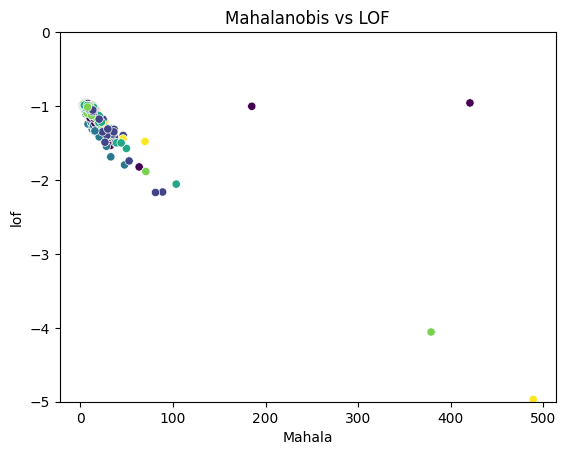

In [36]:
sns.scatterplot(data=scaled_df, x="Mahala", y="lof", c=scaled_df['cluster'].astype(int))
plt.ylim(-5,0)
plt.title("Mahalanobis vs LOF")
#plt.vlines(50, -5, 0, color='red')
#plt.hlines(-2, 0, 500, color='red')
plt.show()

In [37]:
scaled_df_so = scaled_df[(scaled_df['Mahala'] < 100)]# & (scaled_df['lof'] > -1.5)]
scaled_df_so.cluster.value_counts()

cluster
2    146
0    110
1     98
4     94
5     89
3     63
Name: count, dtype: int64

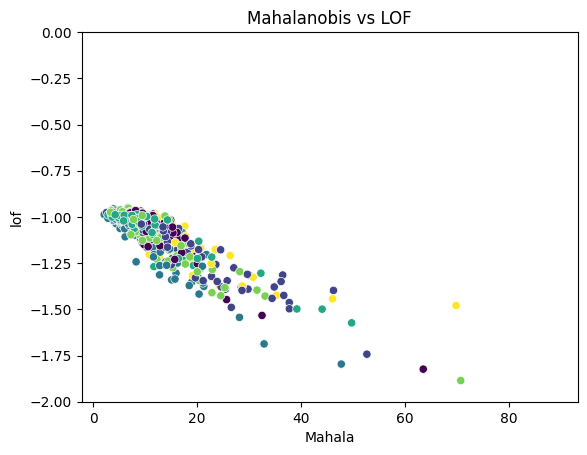

In [38]:
sns.scatterplot(data=scaled_df_so, x="Mahala", y="lof", c=scaled_df_so['cluster'].astype(int))
plt.ylim(-2,0)
plt.title("Mahalanobis vs LOF")
plt.show()

In [39]:
no_std_df_so=estandarizar.inverse_transform(scaled_df_so.drop(columns=['cluster', 'lof', 'Mahala']))
no_std_df_so = pd.DataFrame(no_std_df_so, columns=df_capstone.drop(columns=['Fecha','Turno','Missing Values']).columns)
no_std_df_so['Fecha'] = df_capstone['Fecha'].reset_index(drop=True)
no_std_df_so['Turno'] = df_capstone['Turno'].reset_index(drop=True)
df_capstone=no_std_df_so.copy()
df_capstone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Alim CuT            600 non-null    float64       
 1   Alim CuS            600 non-null    float64       
 2   Alim CuI            600 non-null    float64       
 3   Ag (ppm)            600 non-null    float64       
 4   Pb (ppm)            600 non-null    float64       
 5   Fe %                600 non-null    float64       
 6   Recuperacion_Turno  600 non-null    float64       
 7   P80 Alim Ro300      600 non-null    float64       
 8   pH Ro300            600 non-null    float64       
 9   Tratamiento turno   600 non-null    float64       
 10  Sol Cit             600 non-null    float64       
 11  Aire_Celdas         600 non-null    float64       
 12  Nivel_Celdas        600 non-null    float64       
 13  Fecha               600 non-null    datetime64[ns]

# Test de Kolmogorov-Smirnov

El test de Kolmogorov-Smirnov (KS) es una prueba que compara dos distribuciones de probabilidad para evaluar si provienen de la misma distribución o si una muestra sigue una distribución específica.
Un valor alto del p-value respalda la hipótesis nula, es decir, que no hay evidencia para decir que las distribuciones son diferentes entre si.

In [40]:
common_columns = df_capstone.select_dtypes(include=[np.number]).columns.intersection(df_capstone.select_dtypes(include=[np.number]).columns)

# Realizar el test de Kolmogorov-Smirnov para cada columna numérica

results = []
for column in common_columns:
    if column in df_clean and column in df_capstone:
        stat, p_value = ks_2samp(df_clean[column].dropna(), df_capstone[column])
        results.append((column, stat, p_value))

# Convertir los resultados en un DataFrame para una mejor visualización
results_df = pd.DataFrame(results, columns=['Column', 'KS Statistic', 'P-value'])

# Mostrar los resultados
results_df

,Column,KS Statistic,P-value
0,Alim CuT,0.004050,1.000000
1,Alim CuS,0.003640,1.000000
2,Alim CuI,0.007782,1.000000
3,Ag (ppm),0.035528,0.857247
4,Pb (ppm),0.037724,0.806176
5,Fe %,0.015820,0.999998
6,Recuperacion_Turno,0.004242,1.000000
7,P80 Alim Ro300,0.010580,1.000000
8,pH Ro300,0.006641,1.000000
9,Tratamiento turno,0.002163,1.000000


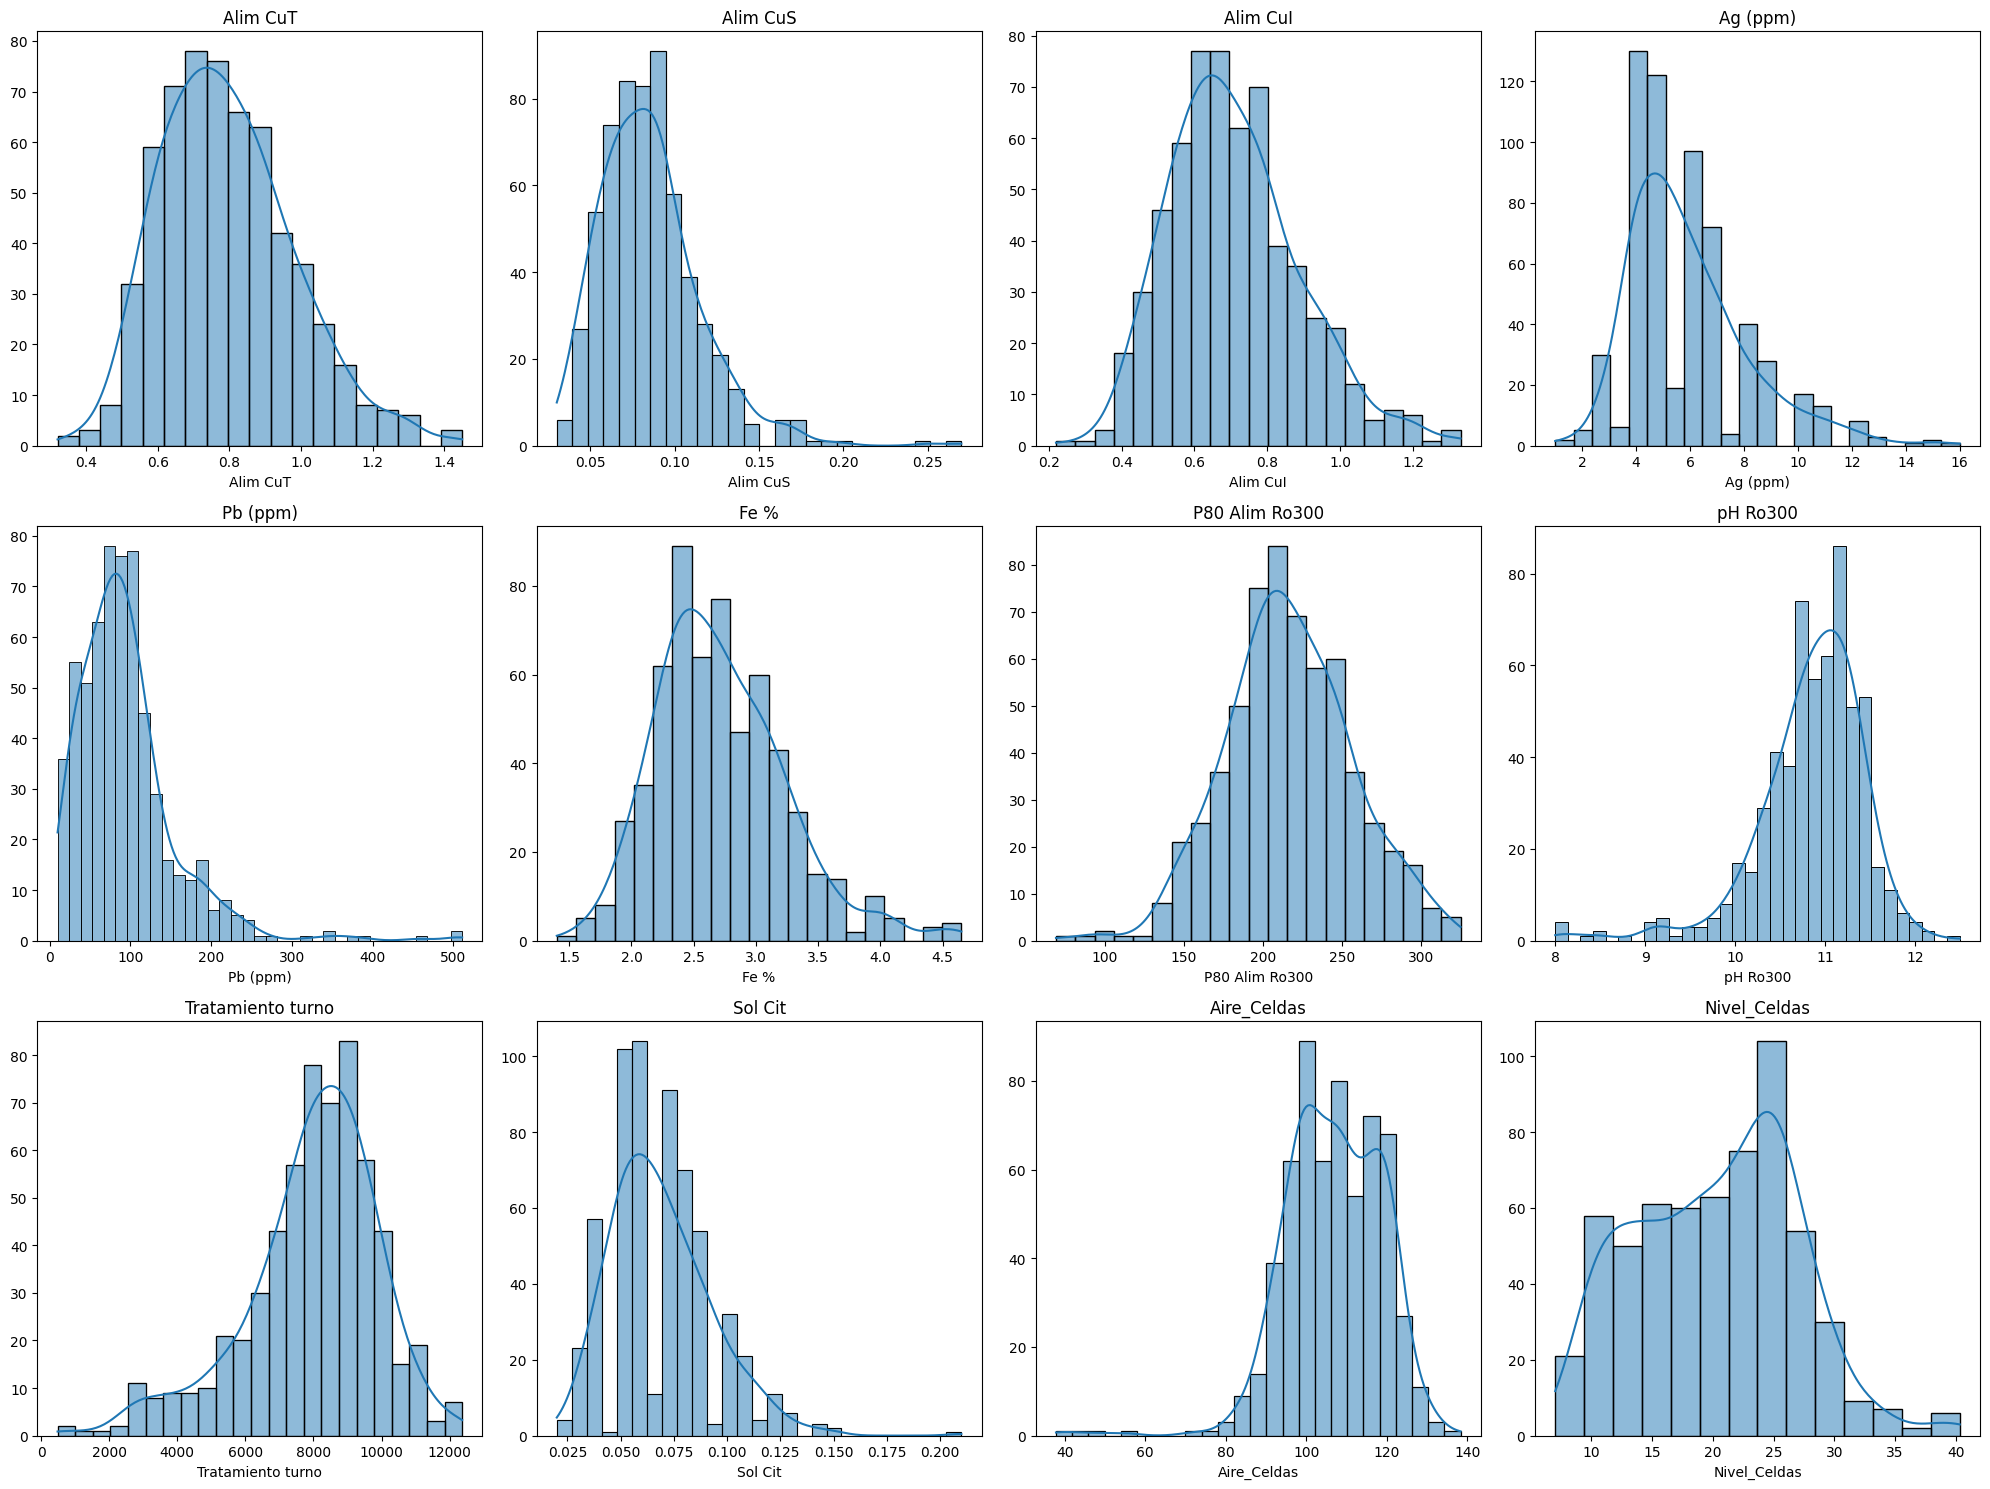

In [41]:
graficos_variables(df_capstone)

# Correlación de las variables

## Gráfico de correlación entre todas las variables

/var/folders/qz/rh86vn897q5crn0p21z7z3qh0000gn/T/ipykernel_19278/1556467894.py:8: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



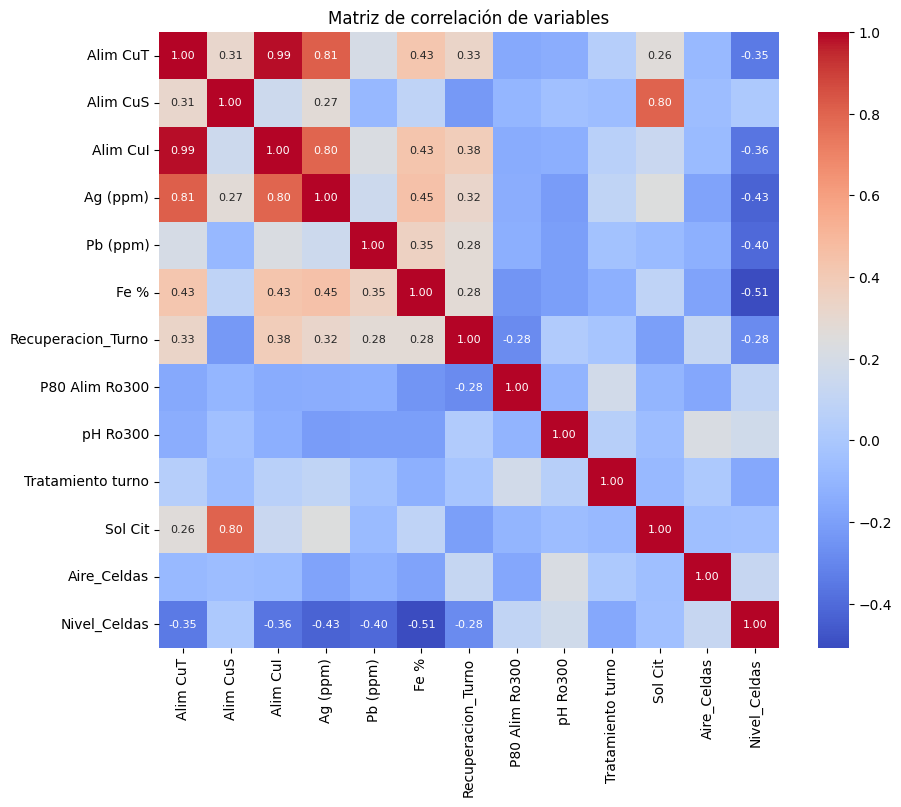

In [42]:
# Calcula la matriz de correlación
correlation_matrix = df_capstone.select_dtypes(include=[np.number]).corr()

# Configura el tamaño de la figura
plt.figure(figsize=(10, 8))

# Crea una matriz de anotaciones personalizada
annotations = correlation_matrix.applymap(lambda x: f'{x:.2f}' if abs(x) >= 0.25 else '')

# Crea un mapa de calor de la matriz de correlación
sns.heatmap(correlation_matrix, annot=annotations, fmt="", cmap="coolwarm", annot_kws={"size": 8})

# Añade etiquetas y título
plt.title("Matriz de correlación de variables")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

## Correlación entre variables predictoras y variable objetivo

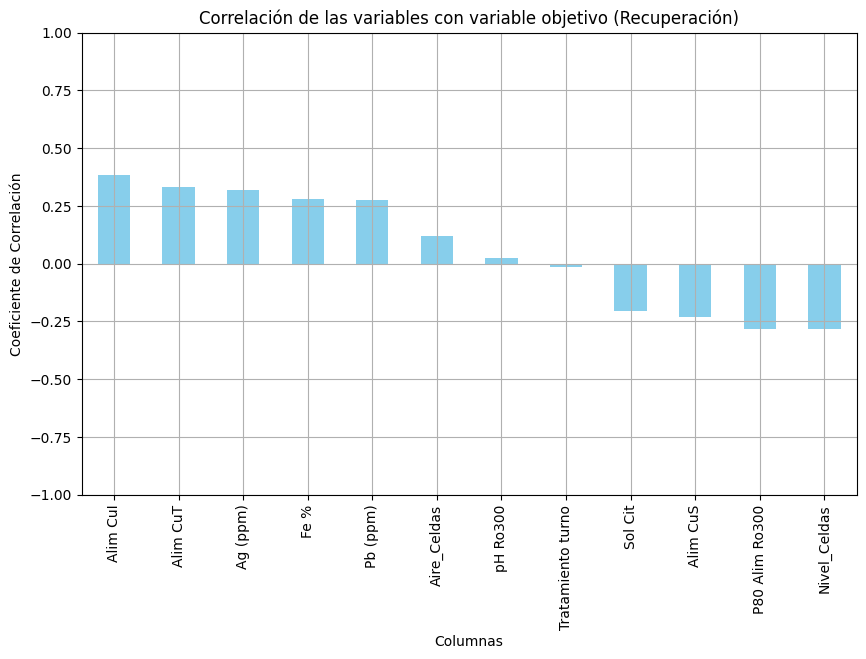

In [43]:
# Extraemos las correlaciones específicas con 'RECUPERACION_PONDERADA'
target_correlation = correlation_matrix['Recuperacion_Turno'].drop('Recuperacion_Turno')  # Excluir la auto-correlación
# Ordenamos las correlaciones de mayor a menor
target_correlation_sorted = target_correlation.sort_values(ascending=False)
# Creamos el gráfico de barras para visualizar estas correlaciones ordenadas
plt.figure(figsize=(10, 6))
target_correlation_sorted.plot(kind='bar', color='skyblue')
plt.title('Correlación de las variables con variable objetivo (Recuperación)')
plt.xlabel('Columnas')
plt.ylabel('Coeficiente de Correlación')
plt.ylim(-1, 1)
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# Revisión de las variables

## Detección de Autocolinealidad (VIF)

In [44]:
df_capstone.drop(columns=['Recuperacion_Turno','Fecha'])

,Alim CuT,Alim CuS,Alim CuI,Ag (ppm),Pb (ppm),Fe %,P80 Alim Ro300,pH Ro300,Tratamiento turno,Sol Cit,Aire_Celdas,Nivel_Celdas,Turno
0,0.70,0.08,0.62,5.0,23.0,2.61,209.0,10.400000,7827.943419,0.0500,109.206438,18.555931,A
1,0.64,0.08,0.56,4.0,29.0,2.72,228.0,11.200000,7863.186581,0.0800,109.041660,21.650116,B
2,0.78,0.09,0.69,4.0,42.0,2.99,198.0,10.800000,6781.529837,0.0800,113.904591,22.948124,A
3,0.60,0.07,0.53,5.0,43.0,2.80,183.0,11.500000,6011.236369,0.0600,117.918102,28.498127,A
4,0.67,0.09,0.58,4.0,36.0,2.78,218.0,11.200000,6420.382068,0.0700,118.092912,28.460662,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.91,0.07,0.84,6.0,120.0,3.67,243.0,10.780000,9459.450000,0.0617,106.473936,9.634823,A
596,0.94,0.09,0.85,5.0,71.0,3.60,247.0,10.566667,7122.060000,0.0683,108.505663,15.414668,B
597,0.72,0.06,0.66,6.0,65.0,2.76,208.0,11.093333,8291.250000,0.0561,104.836123,14.108598,A
598,0.80,0.06,0.74,5.0,228.0,3.19,226.0,10.850000,7264.620000,0.0579,107.879839,13.586933,B


In [45]:
X = df_capstone.drop(columns=['Recuperacion_Turno','Fecha','Turno']) # se elimina la variable Y:medv
X = sm.add_constant(X)

# Calcular el VIF para cada variable predictora
VIF = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Crear un DataFrame para mostrar los resultados tabulados
vif_df = pd.DataFrame({'Variable': X.columns, 'VIF': VIF})

# Mostrar la tabla
display(vif_df.sort_values('VIF', ascending=False))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning:

divide by zero encountered in scalar divide



,Variable,VIF
1,Alim CuT,inf
2,Alim CuS,inf
3,Alim CuI,inf
0,const,734.934728
4,Ag (ppm),3.503266
10,Sol Cit,2.876781
6,Fe %,1.747229
12,Nivel_Celdas,1.716798
5,Pb (ppm),1.340185
7,P80 Alim Ro300,1.205128


In [46]:
X_2 = df_capstone.drop(columns=['Recuperacion_Turno','Fecha','Turno','Alim CuI']) # se elimina la variable Y:medv
X_2 = sm.add_constant(X_2)

# Calcular el VIF para cada variable predictora
VIF_2 = [variance_inflation_factor(X_2.values, i) for i in range(X_2.shape[1])]

# Crear un DataFrame para mostrar los resultados tabulados
vif_df_2 = pd.DataFrame({'Variable': X_2.columns, 'VIF': VIF_2})

# Mostrar la tabla
display(vif_df_2.sort_values('VIF', ascending=False))

,Variable,VIF
0,const,734.934728
3,Ag (ppm),3.503266
1,Alim CuT,3.246286
2,Alim CuS,2.993978
9,Sol Cit,2.876781
5,Fe %,1.747229
11,Nivel_Celdas,1.716798
4,Pb (ppm),1.340185
6,P80 Alim Ro300,1.205128
10,Aire_Celdas,1.165780


## Step Forward Selecction

### Lasso

In [47]:
#linear_model = LinearRegression()
laso=Lasso()
score='explained_variance'
features_select='auto'
#score='neg_root_mean_squared_error',
sfs_model = SequentialFeatureSelector(laso,
                                      n_features_to_select = features_select,
                                      direction='forward',
                                      scoring=score,
                                      cv=5,
                                      n_jobs=-1)

X_sfs = df_capstone.drop(columns=['Recuperacion_Turno','Turno','Fecha','Alim CuI'])
Y_sfs = df_capstone['Recuperacion_Turno']
# Perform SFFS
sfs_model.fit(X_sfs, Y_sfs)

SequentialFeatureSelector(estimator=Lasso(), n_jobs=-1,
                          scoring='explained_variance')

In [48]:
variables_sfs=sfs_model.get_feature_names_out()
variables_sfs

array(['Alim CuT', 'Ag (ppm)', 'Pb (ppm)', 'P80 Alim Ro300',
       'Aire_Celdas'], dtype=object)

In [49]:
X = X_sfs
y = Y_sfs

# Lista para guardar métrica y variable seleccionada
scores = []
variables_seleccionadas = []

remaining_variables = list(X.columns)
selected_variables = []

for i in range(len(remaining_variables)):
    best_score = -float("inf")
    best_variable = None

    for variable in remaining_variables:
        # grupo de variables actuales + la nueva variable
        candidate_variables = selected_variables + [variable]

        # Ajusta el modelo con variables actuales
        model = LinearRegression().fit(X[candidate_variables], y)

        # Calcula el R²
        n = X_sfs.shape[0]  # Número de muestras
        p = X_sfs.shape[1]  # Número de predictores
        r2=r2_score(y, model.predict(X[candidate_variables]))
        r2_adjusted = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        score = r2_adjusted

        # Si el modelo mejora, actualiza el mejor score y variable
        if score > best_score:
            best_score = score
            best_variable = variable

    # Añadir variable y registrar el score
    if best_variable:
        selected_variables.append(best_variable)
        remaining_variables.remove(best_variable)
        scores.append(best_score)
        variables_seleccionadas.append(best_variable)

#print("Variables Seleccionadas:", variables_seleccionadas)
#print("Scores en cada paso:", scores)

results_sfs=pd.DataFrame({'Variables Seleccionadas':variables_seleccionadas,'Scores':scores})
results_sfs


,Variables Seleccionadas,Scores
0,Alim CuT,0.092690
1,Alim CuS,0.218268
2,P80 Alim Ro300,0.282329
3,Pb (ppm),0.300304
4,Aire_Celdas,0.312421
5,Ag (ppm),0.327609
6,pH Ro300,0.332712
7,Fe %,0.336422
8,Sol Cit,0.339208
9,Nivel_Celdas,0.341200


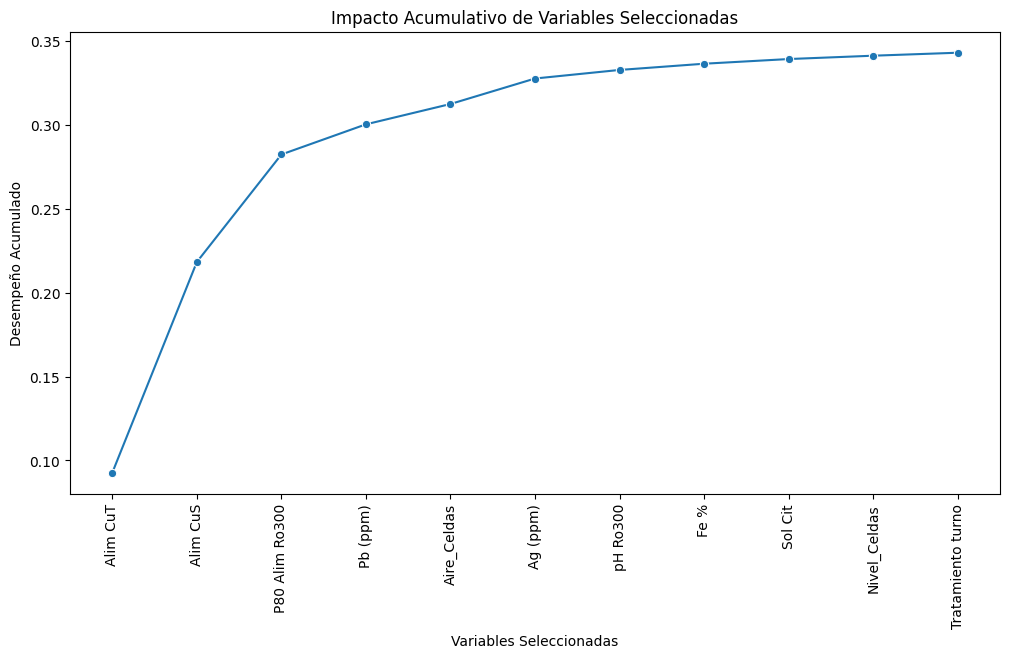

In [50]:
variables_seleccionadas = variables_seleccionadas
scores = scores

plt.figure(figsize=(12, 6))
sns.lineplot(x=variables_seleccionadas, y=scores, marker='o')
plt.xlabel('Variables Seleccionadas')
plt.xticks(rotation=90)
plt.ylabel('Desempeño Acumulado')
plt.title('Impacto Acumulativo de Variables Seleccionadas')
plt.show()

### Random Forest

In [51]:
#linear_model = LinearRegression()
RandomForest=RandomForestRegressor()
score='explained_variance'
features_select='auto'
#score='neg_root_mean_squared_error',
sfs_model_2 = SequentialFeatureSelector(RandomForest,
                                      n_features_to_select = features_select,
                                      direction='forward',
                                      scoring=score,
                                      cv=5,
                                      n_jobs=-1)

X_sfs_2 = df_capstone.drop(columns=['Recuperacion_Turno','Turno','Fecha','Alim CuI'])
Y_sfs_2 = df_capstone['Recuperacion_Turno']
# Perform SFFS
sfs_model_2.fit(X_sfs_2, Y_sfs_2)

SequentialFeatureSelector(estimator=RandomForestRegressor(), n_jobs=-1,
                          scoring='explained_variance')

In [52]:
variables_sfs_2=sfs_model_2.get_feature_names_out()
variables_sfs_2

array(['Ag (ppm)', 'Pb (ppm)', 'Fe %', 'Sol Cit', 'Aire_Celdas'],
      dtype=object)

In [53]:
X = X_sfs_2
y = Y_sfs_2

# Lista para guardar métrica y variable seleccionada
scores = []
variables_seleccionadas = []

remaining_variables = list(X.columns)
selected_variables = []

for i in range(len(remaining_variables)):
    best_score = -float("inf")
    best_variable = None

    for variable in remaining_variables:
        # grupo de variables actuales + la nueva variable
        candidate_variables = selected_variables + [variable]

        # Ajusta el modelo con variables actuales
        model = RandomForestRegressor().fit(X[candidate_variables], y)

        # Calcula el R²
        n = X_sfs_2.shape[0]  # Número de muestras
        p = X_sfs_2.shape[1]  # Número de predictores
        r2=r2_score(y, model.predict(X[candidate_variables]))
        r2_adjusted = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        score = r2_adjusted

        # Si el modelo mejora, actualiza el mejor score y variable
        if score > best_score:
            best_score = score
            best_variable = variable

    # Añadir variable y registrar el score
    if best_variable:
        selected_variables.append(best_variable)
        remaining_variables.remove(best_variable)
        scores.append(best_score)
        variables_seleccionadas.append(best_variable)

#print("Variables Seleccionadas:", variables_seleccionadas)
#print("Scores en cada paso:", scores)

results_sfs_2=pd.DataFrame({'Variables Seleccionadas':variables_seleccionadas,'Scores':scores})
results_sfs_2


,Variables Seleccionadas,Scores
0,Nivel_Celdas,0.818524
1,Tratamiento turno,0.865841
2,Alim CuT,0.875126
3,Alim CuS,0.891266
4,P80 Alim Ro300,0.904112
5,Pb (ppm),0.902681
6,Sol Cit,0.903697
7,Fe %,0.904745
8,Aire_Celdas,0.903437
9,Ag (ppm),0.905469


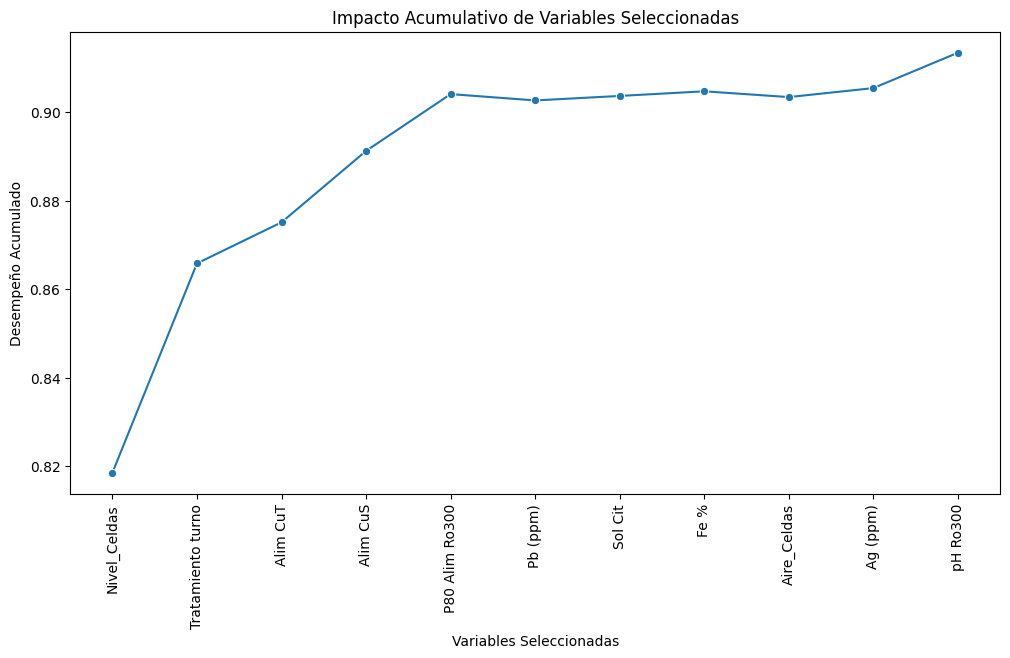

In [54]:
variables_seleccionadas = variables_seleccionadas
scores = scores

plt.figure(figsize=(12, 6))
sns.lineplot(x=variables_seleccionadas, y=scores, marker='o')
plt.xlabel('Variables Seleccionadas')
plt.xticks(rotation=90)
plt.ylabel('Desempeño Acumulado')
plt.title('Impacto Acumulativo de Variables Seleccionadas')
plt.show()

# Archivo

In [78]:
df_capstone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Alim CuT            600 non-null    float64       
 1   Alim CuS            600 non-null    float64       
 2   Alim CuI            600 non-null    float64       
 3   Ag (ppm)            600 non-null    float64       
 4   Pb (ppm)            600 non-null    float64       
 5   Fe %                600 non-null    float64       
 6   Recuperacion_Turno  600 non-null    float64       
 7   P80 Alim Ro300      600 non-null    float64       
 8   pH Ro300            600 non-null    float64       
 9   Tratamiento turno   600 non-null    float64       
 10  Sol Cit             600 non-null    float64       
 11  Aire_Celdas         600 non-null    float64       
 12  Nivel_Celdas        600 non-null    float64       
 13  Fecha               600 non-null    datetime64[ns]

In [79]:
df_capstone.rename({'Tratamiento turno':'Tratamiento_Turno','Ag (ppm)':'Ag','Pb (ppm)':'Pb','Fe %':'Fe','P80 Alim Ro300':'P80_Alim_Ro300','pH Ro300':'pH_Ro300','Alim CuT':'Alim_CuT','Alim CuS':'Alim_CuS','Sol Cit':'Sol_Cit'},axis=1,inplace=True)

In [80]:
df_capstone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Alim_CuT            600 non-null    float64       
 1   Alim_CuS            600 non-null    float64       
 2   Alim CuI            600 non-null    float64       
 3   Ag                  600 non-null    float64       
 4   Pb                  600 non-null    float64       
 5   Fe                  600 non-null    float64       
 6   Recuperacion_Turno  600 non-null    float64       
 7   P80_Alim_Ro300      600 non-null    float64       
 8   pH_Ro300            600 non-null    float64       
 9   Tratamiento_Turno   600 non-null    float64       
 10  Sol_Cit             600 non-null    float64       
 11  Aire_Celdas         600 non-null    float64       
 12  Nivel_Celdas        600 non-null    float64       
 13  Fecha               600 non-null    datetime64[ns]

In [81]:
df_capstone.to_excel('ArchivosExcel/df_capstone.xlsx', index=False)
#df_capstone_sfs.to_excel('/content/drive/MyDrive/Magister/capstone/datos/df_capstone_sfs.xlsx', index=False)